In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DIRECTORY = 'dataset_plus'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='rgb'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 11080 files belonging to 8 classes.
Using 8864 files for training.
Found 11080 files belonging to 8 classes.
Using 2216 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
1122         1099         1101         1104         1127         1094         1119         1098        


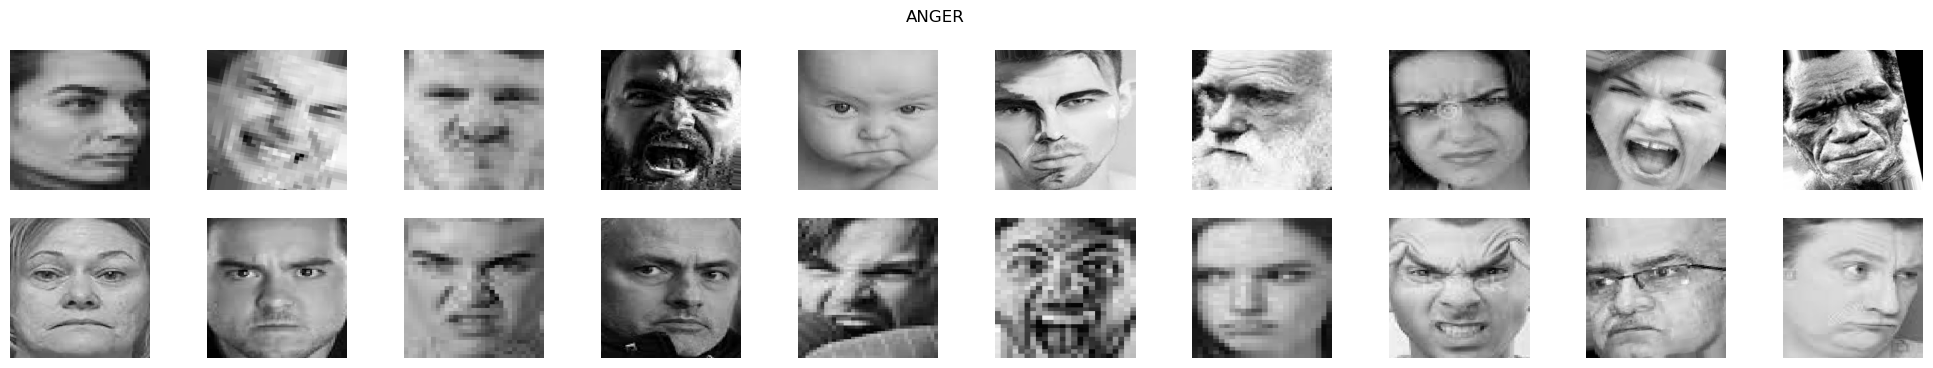

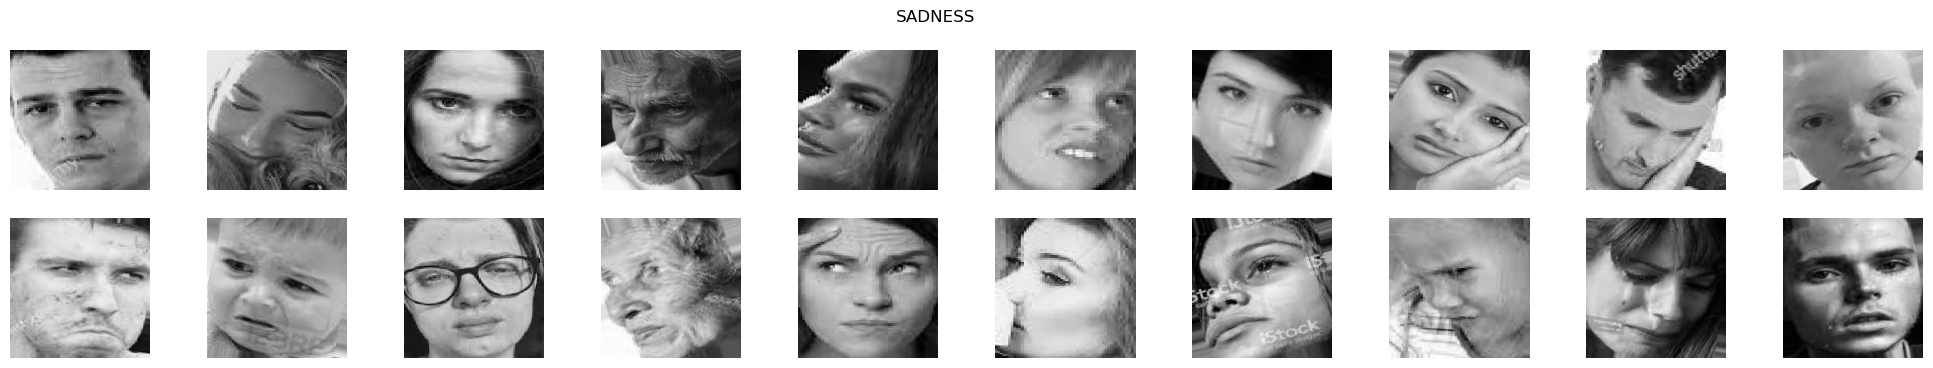

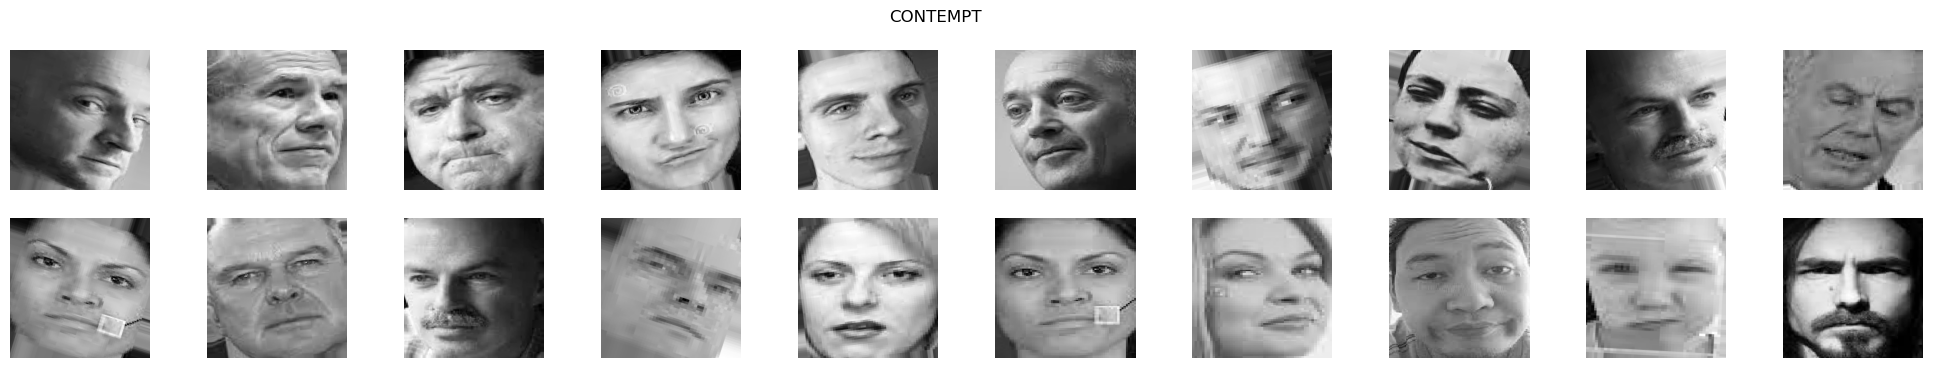

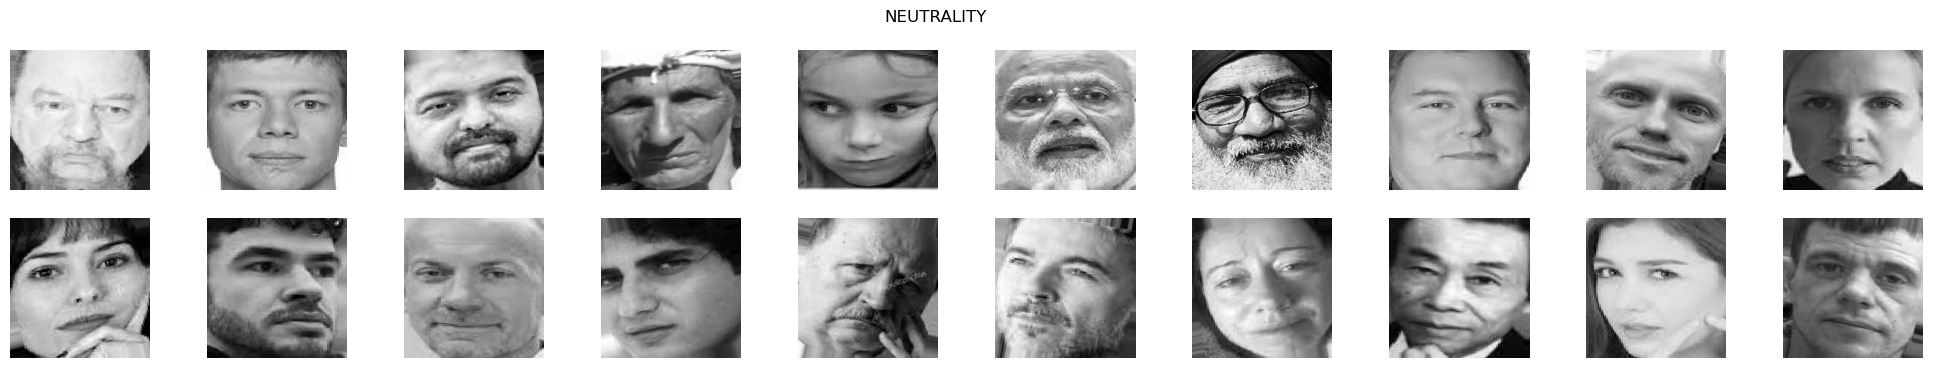

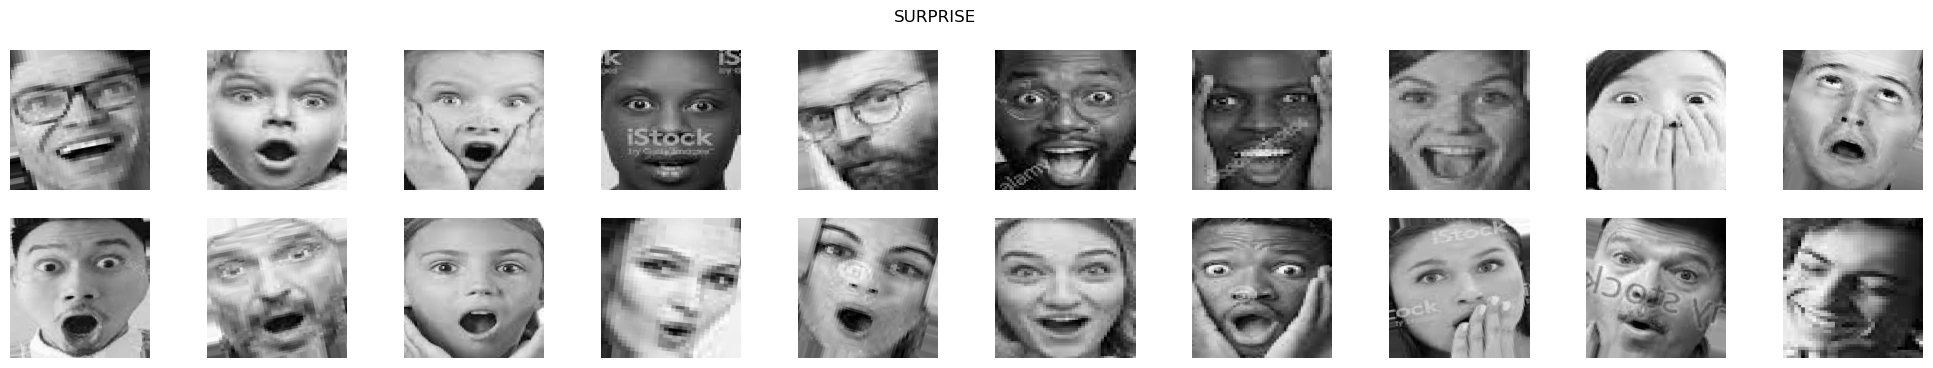

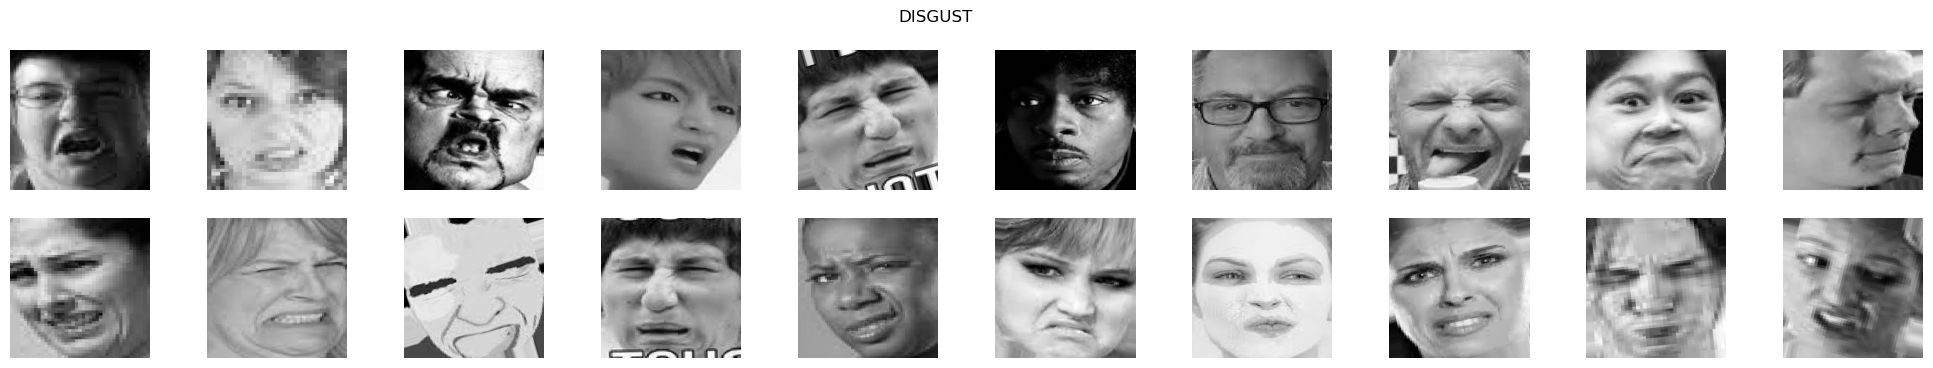

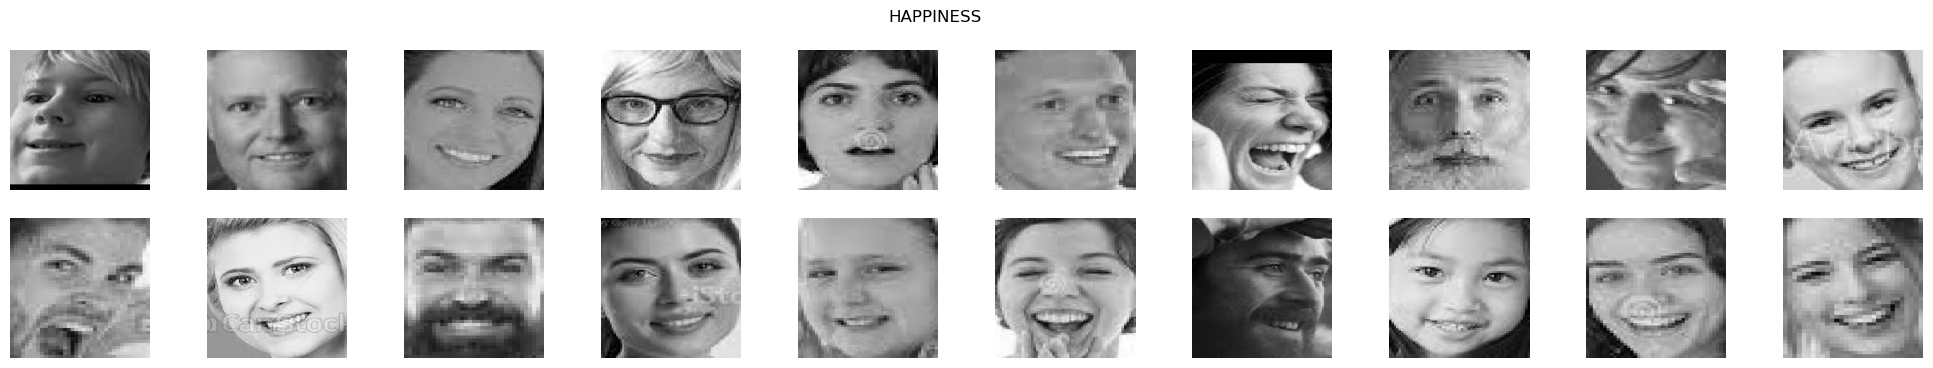

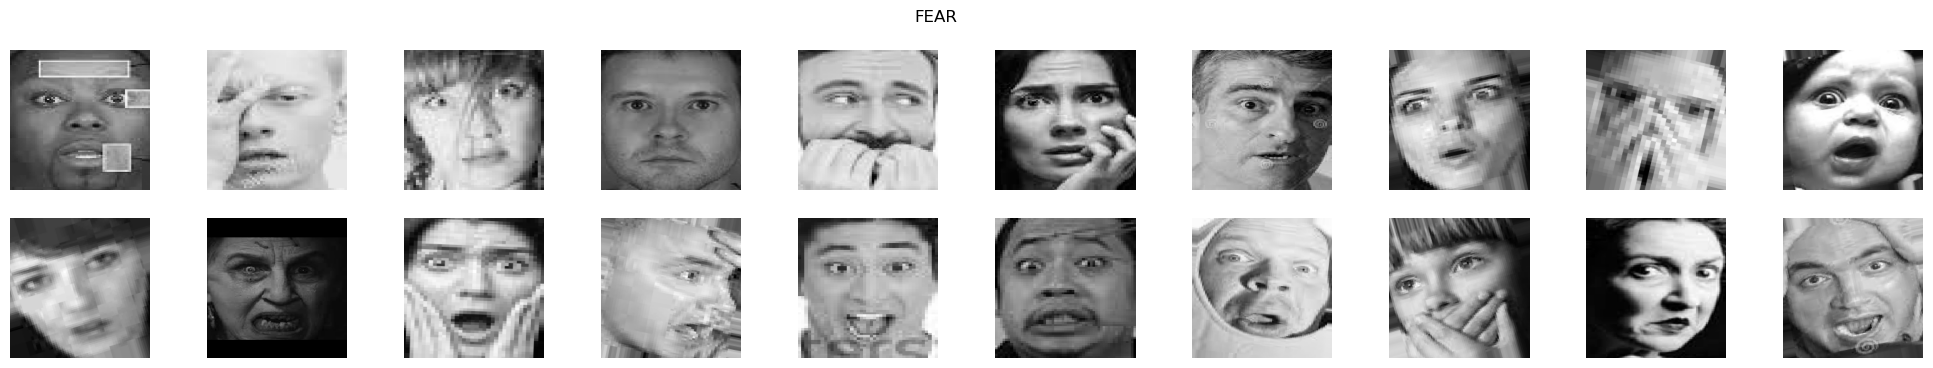

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 139
Number of test batches: 27


In [7]:
# AUTOTUNE = tf.data.AUTOTUNE

train_dataset      = train_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
test_dataset       = test_dataset.cache().prefetch(buffer_size=BATCH_SIZE)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        # , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

2022-12-12 22:25:29.110614: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


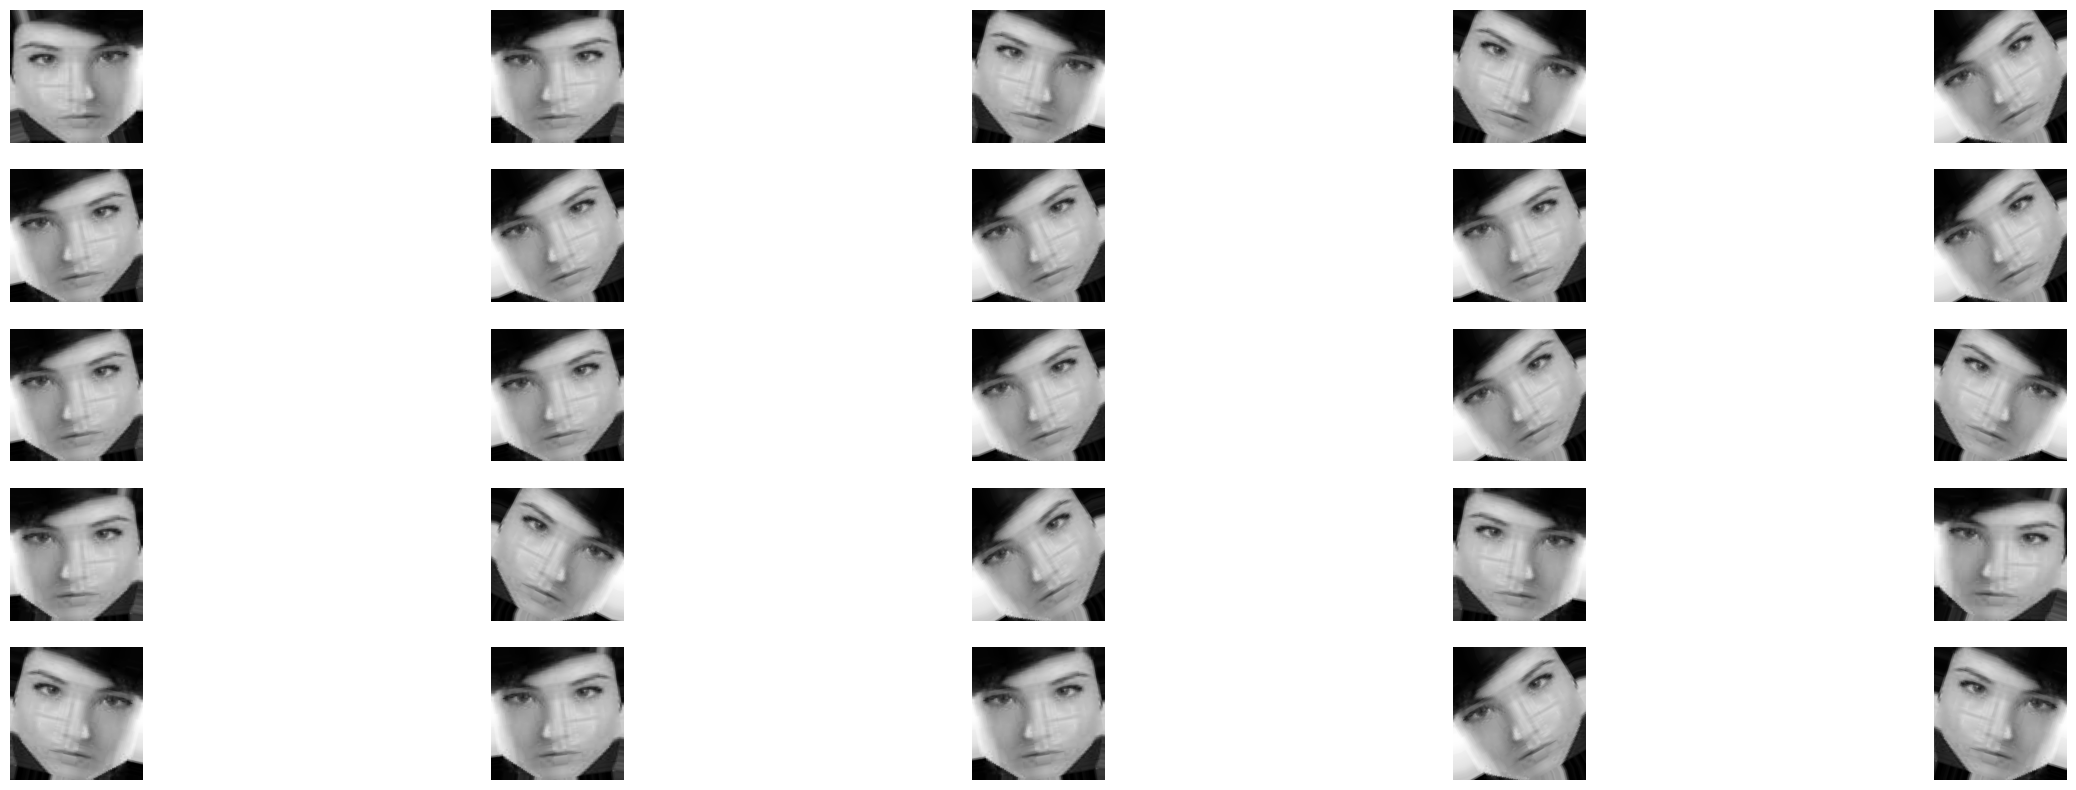

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
model = tf.keras.models.load_model('saved_transferlearn_model_v1/model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 23604104  
                                                                 
Total params: 23,604,104
Trainable params: 4,482,056
Non-trainable params: 19,122,048
_________________________________________________________________


In [10]:
Predictions = []
Labels = []
for image_batch, label_batch in test_dataset:
    predictions = np.argmax(model.predict_on_batch(image_batch), axis=-1)
    Predictions = Predictions + list(predictions)
    Labels = Labels + list(label_batch.numpy())

2022-12-12 22:25:38.538462: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-12 22:25:41.614721: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [11]:
print('{}'.format(list(zip(Predictions, Labels))))

[(4, 4), (1, 1), (4, 4), (7, 7), (3, 7), (2, 2), (4, 4), (6, 6), (0, 5), (0, 6), (1, 1), (2, 2), (0, 0), (1, 1), (3, 0), (0, 0), (7, 7), (5, 5), (1, 1), (5, 5), (4, 4), (2, 2), (4, 6), (7, 4), (3, 3), (3, 3), (1, 1), (4, 5), (4, 6), (3, 3), (0, 2), (2, 0), (6, 6), (4, 4), (3, 3), (5, 5), (3, 0), (7, 7), (1, 6), (0, 7), (3, 3), (5, 5), (3, 3), (4, 4), (4, 4), (4, 4), (7, 7), (0, 6), (6, 5), (4, 4), (3, 3), (3, 3), (5, 5), (5, 5), (7, 7), (2, 2), (3, 3), (7, 7), (6, 6), (4, 0), (3, 0), (2, 2), (0, 0), (0, 0), (7, 7), (3, 3), (3, 3), (1, 1), (0, 5), (2, 2), (5, 3), (0, 6), (4, 4), (3, 7), (5, 5), (4, 4), (7, 7), (7, 7), (1, 1), (6, 6), (7, 2), (4, 4), (4, 3), (4, 2), (7, 7), (7, 7), (4, 4), (4, 4), (6, 0), (5, 5), (4, 4), (5, 5), (0, 0), (3, 0), (3, 3), (0, 5), (0, 6), (7, 7), (3, 3), (4, 4), (4, 4), (0, 0), (2, 2), (1, 1), (1, 1), (5, 1), (0, 7), (4, 4), (6, 6), (1, 1), (4, 4), (5, 5), (7, 7), (0, 1), (7, 7), (5, 3), (5, 5), (5, 5), (2, 2), (0, 5), (7, 0), (3, 3), (4, 0), (3, 3), (0, 1),

In [12]:
print('Confusion matrix')
cm = confusion_matrix(Labels, Predictions)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in cm:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [cm[i,i] for i in range(len(cm))]
den = np.sum(cm, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [cm[i,i] for i in range(len(cm))]
den = np.sum(cm, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
27           1            3            6            3            2            7            2           
4            36           2            1            2            2            3            0           
5            1            25           0            7            0            2            1           
2            0            1            39           5            5            1            4           
3            0            1            0            46           0            2            1           
12           1            1            0            9            39           2            0           
8            5            2            0            10           4            29           1           
2            0            0            6            5            0            1            43          
===
Precision per class
anger        contempt  

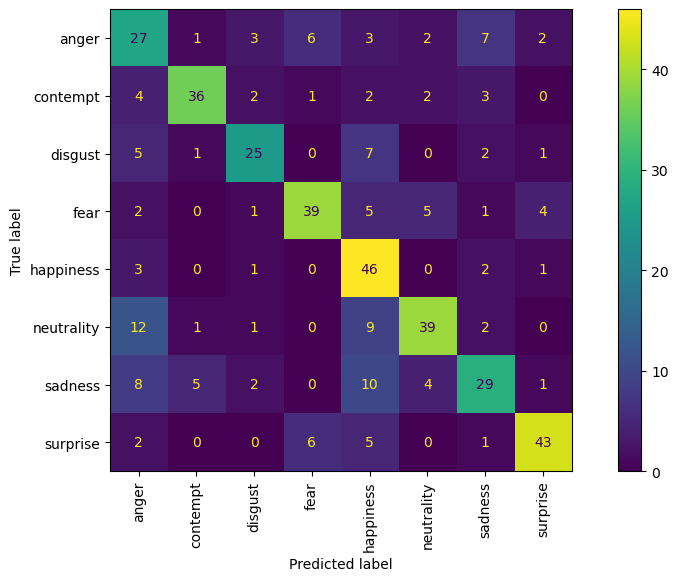

In [13]:
ig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(xticks_rotation='vertical', values_format='d', ax=ax)